In [14]:
import numpy as np
import math
%matplotlib inline
from laspy.file import File
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import rand
import matplotlib.image as mpimg
import os

In [15]:
def colinearite(F,S,R,M):
    RMS = R@(M-S)
    l = F[2]/RMS[2]
    m = F - l * RMS # only makes the z(3rd) coordinate 0.(not very important !)
    # RMS[2] is the depth info we need
    return m, RMS[2]

'''def correct_disto_agisoft(x,y,f,cx,cy,k1,k2,k3,k4,p1,p2,p3,p4,b1,b2,w,h):
    x = x / f
    y = y / f
    r2 = pow(x,2)+pow(y,2)
    xp = x*(1
            + k1*r2
            + k2*pow(r2,2)
            + k3*pow(r2,3)
            + k4*pow(r2,4))\
            + (p1*(r2+2*pow(x,2))+2*p2*x*y)*(1+p3*r2+p4*pow(r2,2))
    yp = y*(1
            + k1*r2
            + k2*pow(r2,2)
            + k3*pow(r2,3)
            + k4*pow(r2,4))\
            + (p2*(r2+2*pow(y,2))+2*p1*x*y)*(1+p3*r2+p4*pow(r2,2))
    u = w/2+cx-xp*f-xp*b1-yp*b2
    v = h/2+cy+yp*f
    return u,v'''

def readOPKFile(filename):
    # Exported Cameras from Agisoft format OPK
    # PhotoID, X, Y, Z, Omega, Phi, Kappa, r11, r12, r13, r21, r22, r23, r31,r32, r33
    out = {}
    with open(filename) as f:
        for l in f:
            if l.startswith("#"):
                continue
            l = l.split()
            x,y,z = float(l[1]),float(l[2]),float(l[3])
            S = np.asarray([[x,y,z]]).T
            Rtemp = [float(l[i]) for i in range(7,16)]
            R = np.array([
                [Rtemp[0], Rtemp[1], Rtemp[2]],
                [Rtemp[3], Rtemp[4], Rtemp[5]],
                [Rtemp[6], Rtemp[7], Rtemp[8]],
            ])
            
            out[l[0]] = [S,R]
    return out

# define read file for camera(calib) xml file
import xml.etree.ElementTree as ET
def read_calib(filename):
    tree = ET.parse(filename)
    root = tree.getroot()
    
    # read the data into l: width, height, f, cx, cy, b1, b2, k1, k2, k3, k4, p1, p2
    l = []
    for child in root:
         if child.tag not in ['projection', 'date']:
            l.append(float(child.text))
    return l

# we analyse scene by scene

In [20]:
scenes_lidar = ['/Jussy1_rtc360_subsampled_classified_georef.las', 
               '/Jussy2_rtc360_subsampled_classified_georef.las',
               '/Jussy3_rtc360_subsampled_classified_georef.las',
               '/Athenaz_rtc360_subsampled_classified.las', '/Athenaz_rtc360_subsampled_classified.las', '/Athenaz_rtc360_subsampled_classified.las',
               '/Tram_rtc360_subsampled_classified.las', '/Tram_rtc360_subsampled_classified.las', '/Tram_rtc360_subsampled_classified.las',
               '/planlesouates_rc360_subsampled_classified.las', 
               '/Champel_rtc360_subsampled_classified.las','/Champel_rtc360_subsampled_classified.las',
               '/Pictet_rtc360_subsampled_classified.las', '/Pictet_rtc360_subsampled_classified.las']



scenes_opk = ['/Jussy1_opk.txt',
             '/Jussy2_opk.txt',
             '/Jussy3_opk.txt',
             '/athenaz_opk.txt', '/athenaz_iphone_video_camera_opk.txt', '/athenaz_iphone_img_opk.txt', #athenaz
             '/Tram_opk.txt', '/tram_ktm_opk.txt', '/Tram_opk.txt',
             '/planlesouates_opk.txt',
              '/champel_opk.txt', '/champel_opk.txt',
              '/pictet_opk.txt', '????'
             ]


scenes_calib = ['/Jussy1_calib_cam.xml',
               '/Jussy2_calib_cam.xml',
               '/Jussy3_camera_calib.xml',
               '/athenaz_calib_cam.xml', '/athenaz_iphone_video_camera_cali.xml', '/athenaz_iphone_img_camera_cali.xml',  #athenaz
               '/tram_camera_calib.xml', '/tram_ktm_camera_calib.xml', '/Tram_camera_calibration.xml',
               '/planlesouates_camera_calib.xml',
               '/champel_camera_calib.xml', '/champel_camera_calib.xml',
               '/pictet_camera_calib.xml', '????'
               ]



scenes_folder = ['/01_jussy1',
                '/01_jussy2',
                '/01_jussy3',
                '/02_athenaz', '/02_athenaz', '/02_athenaz',
                '/04_tram', '/04_tram', '/04_tram',
                '/05_plan_les_ouates',
                '/06_champel', '/06_champel',
                '/07_pictet', '/07_pictet']



photo_folders = ['/photo_sony', 
                 '/photo_sony', 
                 '/photo_sony',
                '/photo_sony', '/photo_iphone_video', '/photo_iphone_img',  #athenaz
                '/photo_sony', '/photo_ktm', '/photo_iphone_video', #Tram
                '/photo_sony', # plan ouates
                '/photo_sony', '/photo_iphone_video',# champel
                '/photo_sony', '/photo_iphone_video']

photo_type = ['/JPG/', 
              '/JPG/', 
              '/JPG/',
             '/JPG/', '/BMP/', '/JPG/',  # athenaz
             '/JPG/', '/JPG/', '/BMP/', # Tram
             '/JPG/', # plan ouates
             '/JPG/', '/BMP/', # champel
             '/JPG/', '/BMP/'] # pictet

save_folders = ['jussy1_sampels/',
               'jussy2_sampels/',
               'jussy3_sampels/',
               'athenaz_sampels_sony/', 'athenaz_sampels_iphone_video/', 'athenaz_sampels_iphone_img/',
               'tram_sampels_sony/', 'tram_sampels_ktm/', 'tram_sampels_iphone_video/',
               'plan_ouates_sampels/',
               'champel_sampels_sony/', 'champel_sampels_iphone_video/',
               'pictet_sampels_sony/', 'pictet_sampels_iphone_video/']

bin_widths = [35, 
              15,
              15, 
              15, 5, 10,
              15, 3, 3, # 8 (Tram)
              15, # 9
              15, 3, # (champel)
              15, 5]

# image dimensions. used to crop
# in order height_y, width_x
img_dims = [[6336, 9504],
            [6336, 9504],
            [6336, 9504], 
            [6336, 9504], [1080, 1920], [3024, 4032], # athenaz
            [6336, 9504], [1440,1920], [1080, 1920], # tram
            [6336, 9504],
            [6336, 9504], [1920,1080], # champel
            [6336, 9504]
           ]

In [17]:
# make the save directories
'''from pathlib import Path

for folder in save_folders:
    try:
        Path('lidar_sampels/' + folder[0:-1]).mkdir()
    except FileExistsError:
        print('%s already exists'%folder)'''


"from pathlib import Path\n\nfor folder in save_folders:\n    try:\n        Path('lidar_sampels/' + folder[0:-1]).mkdir()\n    except FileExistsError:\n        print('%s already exists'%folder)"

In [12]:
# from 0 to 13
scene_number = 1

data_path = '/cvlabsrc1/cvlab/dataset_sbb/data'

calib_file = data_path + scenes_folder[scene_number] + photo_folders[scene_number] + scenes_calib[scene_number]
opk_file = data_path + scenes_folder[scene_number] + photo_folders[scene_number] + scenes_opk[scene_number]
lidar_file = data_path + scenes_folder[scene_number] + '/clouds' + scenes_lidar[scene_number]

photo_path = data_path + scenes_folder[scene_number] + photo_folders[scene_number]+ photo_type[scene_number]

save_path ='lidar_sampels/'+save_folders[scene_number]

bin_width = bin_widths[scene_number]

In [13]:
bin_width

15

In [14]:
calib_file

'/cvlabsrc1/cvlab/dataset_sbb/data/01_jussy2/photo_sony/Jussy2_calib_cam.xml'

In [16]:
# using read file functions

# calib file for this scene (if this lines throws an error b/c of missing values they should be considered 0)
w, h, f, cx, cy, b1, b2, k1, k2, k3, k4, p1, p2 = read_calib(calib_file)
F = np.array([[0,0,-f]]).T
p3=p4=0 

# OPK file for all photos
opks = readOPKFile(opk_file)

In [17]:
# read the lidar file
lidar_inFile = File(lidar_file, mode = "r")
points = np.vstack((lidar_inFile.x, lidar_inFile.y, lidar_inFile.z, 
                    lidar_inFile.red, lidar_inFile.green, lidar_inFile.blue )).T

In [18]:
points.shape

(475353, 6)

In [18]:
def cut(image_points, width_x, height_y):
    '''select the image points that are in the valid image range
    defined by width_x and height_y.'''
    points = image_points
    
    x = points[:,0]
    y = points[:,1]
    
    x_mask = (0<=x) & (x<=width_x)
    y_mask = (0<=y) & (y<=height_y)
    mask = x_mask & y_mask
    
    cut_image = points[mask]
    
    return cut_image

def discretize(image_points, bin_width):
    '''discretize the pixel values by binning into bin_width.
    technically dividing by bin_width and then taking floor by casting to int'''
    points = image_points
    
    # get the discrete x and y pixels
    x_pixel = (points[:,0]/bin_width).astype(int)
    y_pixel = (points[:,1]/bin_width).astype(int)

    points[:,0] = x_pixel
    points[:,1] = y_pixel
    
    return points

In [20]:
def redo_scene(key, bin_width, plot_result=False):
    '''this is for visualizing and doing single view of a single scene'''
    # get transofm matricies
    S, R = opks[key]
    
    # get the desired coord from 3d to image coords
    M = points[:,0:3].T
    m, depth = colinearite(F,S,R,M)
    x,y = correct_disto_agisoft(m[0,:],m[1,:],
                        f,cx,cy,k1,k2,k3,k4,p1,p2,p3,p4,b1,b2,w,h)
    # add depth column
    x_y_depth = np.vstack([x, y, depth]).T
    
    # add color incase we need to plot
    image_points = np.concatenate((x_y_depth, points[:,3:]), axis=1)
    
    # make index column add it to the end of the image_points
    indices = np.arange(image_points.shape[0])
    image_points = np.c_[ image_points, indices ]
    
    # read the real photo to get the dimensions
    photo_file = photo_path+key+ '.' + photo_type[scene_number][1:-1]
    
    try:
        img=mpimg.imread(photo_file)
    except FileNotFoundError:
        photo_file = photo_path+key+ '.' + str.lower(photo_type[scene_number][1:-1])
        img=mpimg.imread(photo_file)
        
    height_y, width_x, _ = img.shape
    # plot
    plt.imshow(img)
    plt.show()

    
    # first crop the image_points into the real photo dimension
    cropped_image = cut(image_points, width_x, height_y)

    print('x', np.max(image_points[:,0]),  np.min(image_points[:,0]))
    print('y', np.max(image_points[:,1]),  np.min(image_points[:,1]))
    print('width, height',  width_x, height_y)

    # get the discrete x and y pixels
    discrete_image = discretize(cropped_image, bin_width)
    
    # use pandas to groupby pixel and take points that have max depth in each pixel
    df = pd.DataFrame(discrete_image, columns=['x_pixel', 'y_pixel', 'depth', 'r', 'g','b', 'original_index'])
    df = df.astype({'x_pixel': 'int32', 'y_pixel':'int32'})
    idx = df.groupby(['x_pixel', 'y_pixel'])['depth'].transform(max) == df['depth']
    closest_points = df[idx]
    
    print('closest', closest_points.shape)
    
    
    # plot result
    if plot_result:
        print('plotting the result ...')
        sample = closest_points.to_numpy()
        rgb = sample[:,3:6]
        rgb_normalized = rgb/ np.max(rgb, axis=0)
        # scatter plot
        plt.figure(figsize=(10, 8)) 
        plt.scatter(sample[:,0], -1*sample[:,1], marker='.', color=rgb_normalized, s=0.2)
        plt.show()
        
    
    # get the indices of selected points (last column)
    indices = closest_points.iloc[:,-1].to_numpy().astype(int)
    
    # select points and store as las file again
    selection = lidar_inFile.points[indices]
    
    print(len(selection))
    
    outFile = File('lidar_sampels/'+key+"_sample.las", mode = "w",
                header = lidar_inFile.header)
    outFile.points = selection
    outFile.close()
    
    print('finished: '+ key)

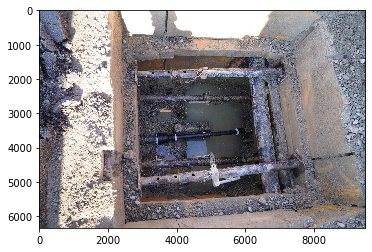

x 9.551217795587917e+44 -3.2167680966341783e+50
y 3.5869884629443356e+50 -3.0939445880994507e+46
width, height 9504 6336
closest (113975, 7)
plotting the result ...


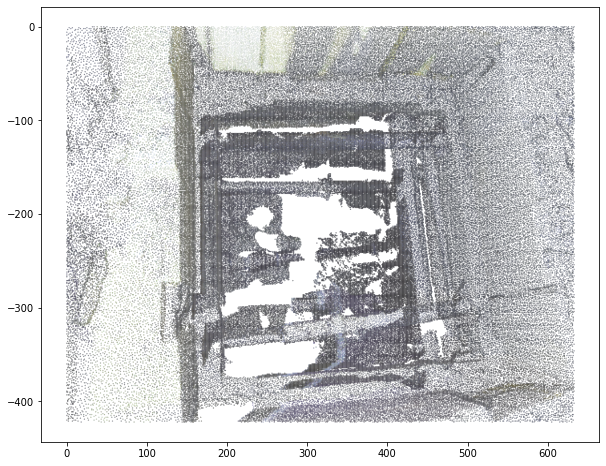

113975
finished: DSC00546


In [301]:
redo_scene('DSC00546', 15, plot_result=True)

In [22]:
def sample_scene(key, bin_width, height_y, width_x):
    # get transofm matrixes
    S, R = opks[key]
    
    # get the desired coord from 3d to image coords
    M = points[:,0:3].T
    m, depth = colinearite(F,S,R,M)
    x,y = correct_disto_agisoft(m[0,:],m[1,:],
                        f,cx,cy,k1,k2,k3,k4,p1,p2,p3,p4,b1,b2,w,h)
    
    # add depth column
    x_y_depth = np.vstack([x, y, depth]).T
    
    # don't add color
    image_points = x_y_depth
    
    # make index column add it to the end of the image_points
    indices = np.arange(image_points.shape[0])
    image_points = np.c_[ image_points, indices ]
    

    # first crop the image_points into the real photo dimension
    cropped_image = cut(image_points, width_x, height_y)

    # get the discrete x and y pixels
    discrete_image = discretize(cropped_image, bin_width)
    
    # use pandas to groupby pixel and take points that have max depth in each pixel
    df = pd.DataFrame(discrete_image, columns=['x_pixel', 'y_pixel', 'depth', 'original_index'])
    df = df.astype({'x_pixel': 'int32', 'y_pixel':'int32'})
    idx = df.groupby(['x_pixel', 'y_pixel'])['depth'].transform(max) == df['depth']
    closest_points = df[idx]
    
    # get the indices of selected points (last column)
    indices = closest_points.iloc[:,-1].to_numpy().astype(int)
    
    # select points and store as las file again
    selection = lidar_inFile.points[indices]
    
    outFile = File(save_path+key+"_sample.las", mode = "w",
                header = lidar_inFile.header)
    outFile.points = selection
    outFile.close()

In [23]:
# this code should be used for processing multiple scenes
data_path = '/cvlabsrc1/cvlab/dataset_sbb/data'
scenes_todo = [0,1,2,3,4,5,6,7,8,9,10,11] 
for scene_number in scenes_todo:
    print('\n////////////////////////////////////////')
    print('sampeling scene %d'%scene_number)
    
    # get the file paths
    calib_file = data_path + scenes_folder[scene_number] + photo_folders[scene_number] + scenes_calib[scene_number]
    opk_file = data_path + scenes_folder[scene_number] + photo_folders[scene_number] + scenes_opk[scene_number]
    lidar_file = data_path + scenes_folder[scene_number] + '/clouds' + scenes_lidar[scene_number]

    photo_path = data_path + scenes_folder[scene_number] + photo_folders[scene_number]+ photo_type[scene_number]

    save_path ='lidar_sampels/'+save_folders[scene_number]

    bin_width = bin_widths[scene_number]
    
    
    # calib file for this scene
    w, h, f, cx, cy, b1, b2, k1, k2, k3, k4, p1, p2 = read_calib(calib_file)
    F = np.array([[0,0,-f]]).T
    p3=p4=0 

    # OPK file for all photos
    opks = readOPKFile(opk_file)
    
    # read the lidar file
    lidar_inFile = File(lidar_file, mode = "r")
    points = np.vstack((lidar_inFile.x, lidar_inFile.y, lidar_inFile.z, 
                        lidar_inFile.red, lidar_inFile.green, lidar_inFile.blue )).T
    
    # get the photo dimesnions for this type of scene
    height_y, width_x = img_dims[scene_number]
    
    for key, value in opks.items():
        sample_scene(key, bin_widths[scene_number], height_y, width_x)
        print('finished: '+ key)


////////////////////////////////////////
sampeling scene 0
finished: DSC00528
finished: DSC00529
finished: DSC00530
finished: DSC00531
finished: DSC00532
finished: DSC00533
finished: DSC00534
finished: DSC00535
finished: DSC00536
finished: DSC00537
finished: DSC00538
finished: DSC00539
finished: DSC00540
finished: DSC00541
finished: DSC00542
finished: DSC00543
finished: DSC00544
finished: DSC00545
finished: DSC00546
finished: DSC00547
finished: DSC00548
finished: DSC00549
finished: DSC00550
finished: DSC00551
finished: DSC00552
finished: DSC00553
finished: DSC00554
finished: DSC00555
finished: DSC00556
finished: DSC00557
finished: DSC00558
finished: DSC00559
finished: DSC00560

////////////////////////////////////////
sampeling scene 1
finished: DSC00561
finished: DSC00562
finished: DSC00563
finished: DSC00564
finished: DSC00565
finished: DSC00566
finished: DSC00567
finished: DSC00568
finished: DSC00569
finished: DSC00570
finished: DSC00571
finished: DSC00572
finished: DSC00573
finish

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/farivar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-03d5eef38b01>", line 37, in <module>
    sample_scene(key, bin_widths[scene_number], height_y, width_x)
  File "<ipython-input-22-6f9da44569d2>", line 9, in sample_scene
    f,cx,cy,k1,k2,k3,k4,p1,p2,p3,p4,b1,b2,w,h)
  File "<ipython-input-2-351e6596667c>", line 16, in correct_disto_agisoft
    + k4*pow(r2,4))\
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/farivar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most rece

KeyboardInterrupt: 

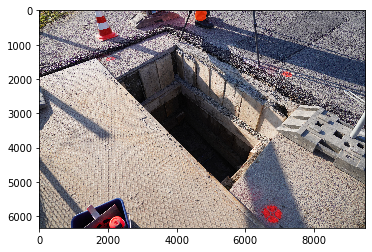

finished: DSC00561
finished: DSC00562
finished: DSC00563
finished: DSC00564
finished: DSC00565
finished: DSC00566
finished: DSC00567
finished: DSC00568
finished: DSC00569
finished: DSC00570


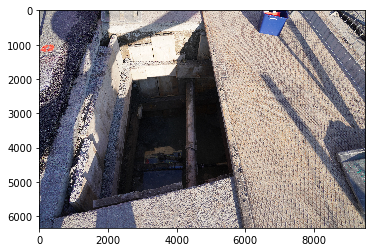

finished: DSC00571
finished: DSC00572
finished: DSC00573
finished: DSC00574
finished: DSC00575
finished: DSC00576
finished: DSC00577
finished: DSC00578
finished: DSC00579
finished: DSC00580


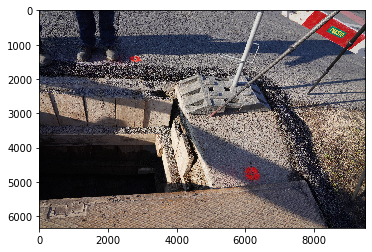

finished: DSC00581
finished: DSC00582
finished: DSC00583
finished: DSC00584
finished: DSC00585


In [22]:
# this is used for processing a single scene

# for each image calculate the transform
counter = 0 
for key, value in opks.items():
    # get transofm matrixces
    S, R = value
    
    # get the desired coord from 3d to image coords
    M = points[:,0:3].T
    m, depth = colinearite(F,S,R,M)
    x,y = correct_disto_agisoft(m[0,:],m[1,:],
                        f,cx,cy,k1,k2,k3,k4,p1,p2,p3,p4,b1,b2,w,h)
    
    # add depth column
    x_y_depth = np.vstack([x, y, depth]).T
    
    # add color incase we need to plot
    image_points = np.concatenate((x_y_depth, points[:,3:]), axis=1)
    
    # make index column add it to the end of the image_points
    indices = np.arange(image_points.shape[0])
    image_points = np.c_[ image_points, indices ]
    
    # read the real photo to get the dimensions
    photo_file = photo_path+key+ '.' + photo_type[scene_number][1:-1]
    
    try:
        img=mpimg.imread(photo_file)
    except FileNotFoundError:
        photo_file = photo_path+key+ '.' + str.lower(photo_type[scene_number][1:-1])
        img=mpimg.imread(photo_file)
    
    
    height_y, width_x, _ = img.shape
    # only plot 2/3 photos
    if counter%10 == 0 and counter<=30:
        plt.imshow(img)
        plt.show()
    counter+=1
    
    # first crop the image_points into the real photo dimension
    cropped_image = cut(image_points, width_x, height_y)


    # get the discrete x and y pixels
    discrete_image = discretize(cropped_image, bin_width)
    
    # use pandas to groupby pixel and take points that have max depth in each pixel 
    # (deeper points are more negative so we choose closer points)
    df = pd.DataFrame(discrete_image, columns=['x_pixel', 'y_pixel', 'depth', 'r', 'g','b', 'original_index'])
    df = df.astype({'x_pixel': 'int32', 'y_pixel':'int32'})
    idx = df.groupby(['x_pixel', 'y_pixel'])['depth'].transform(max) == df['depth']
    closest_points = df[idx]
    
    # get the indices of selected points (last column)
    indices = closest_points.iloc[:,-1].to_numpy().astype(int)
    
    # select points and store as las file again
    selection = lidar_inFile.points[indices]
    
    
    outFile = File(save_path+key+"_sample.las", mode = "w",
                header = lidar_inFile.header)
    outFile.points = selection
    outFile.close()
    
    print('finished: '+ key)